<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [26]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

### 1) Clean: Job Listings from indeed.com that contain the title "Data Scientist"

You have job_listings.csv in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the BeautifulSoup library to clean up this column. You will need to read thru the documentation to accomplish this task.

Tip: You will need to install the bs4 library inside your conda environment.

In [27]:
from bs4 import BeautifulSoup
import requests

df = pd.read_csv('./data/job_listings.csv')

df['description'] = [BeautifulSoup(text).get_text() for text in df['description']]

df['description'] = df['description'].map(lambda x: x.replace('b"', ''))
df['description'] = df['description'].map(lambda x: x.replace("b'", ''))
df['description'] = df['description'].map(lambda x: x.replace("'", ''))
df = df.replace(r'\\n',' ', regex=True) 

df.head()

,Unnamed: 0,description,title
0,0,Job Requirements: Conceptual understanding in ...,Data scientist
1,1,"Job Description As a Data Scientist 1, you wi...",Data Scientist I
2,2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level
3,3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist
4,4,Location: USA \xe2\x80\x93 multiple locations ...,Data Scientist


## 2) Use Spacy to tokenize / clean the listings 

In [28]:
# create a copy of the df to use Spacy for review:
df_spacy = df.copy()


In [29]:
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [30]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(df_spacy['description'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df_spacy['tokens'] = tokens

In [36]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas


df_spacy['lemmas'] = df_spacy['description'].apply(get_lemmas)

In [37]:
print(df_spacy.shape)
df_spacy.head()

(426, 5)


,Unnamed: 0,description,title,tokens,lemmas
0,0,Job Requirements: Conceptual understanding in ...,Data scientist,"[job, requirements:, conceptual, understanding...","[job, requirement, conceptual, understanding, ..."
1,1,"Job Description As a Data Scientist 1, you wi...",Data Scientist I,"[job, description, , data, scientist, 1,, hel...","[job, description, , Data, Scientist, 1, help..."
2,2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level,"[data, scientist, working, consulting, busines...","[Data, scientist, work, consult, business, res..."
3,3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist,"[$4,969, $6,756, monthcontractunder, general, ...","[$, 4,969, $, 6,756, monthcontractunder, gener..."
4,4,Location: USA \xe2\x80\x93 multiple locations ...,Data Scientist,"[location:, usa, \xe2\x80\x93, multiple, locat...","[location, USA, \xe2\x80\x93, multiple, locati..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [32]:
# create the transformer:
vect = CountVectorizer(stop_words='english')

# learn vocab:
vect.fit(df['description'])

# get dtm (document term matrix):
dtm = vect.transform(df['description'])

# transform into dense dataframe from sparse matrix:
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

dtm.head()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
dtm.shape
# make sure matches rows in df_spacy

(426, 8567)

## 4) Visualize the most common word counts

In [34]:
from collections import Counter
import squarify
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

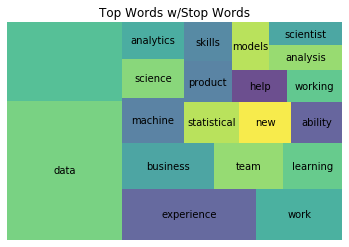

In [38]:
wc = count(df_spacy['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.title('Top Words w/Stop Words')
plt.show()

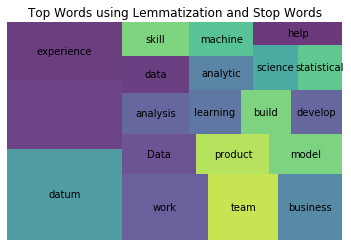

In [39]:
wc = count(df_spacy['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.title('Top Words using Lemmatization and Stop Words')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [48]:
# instantiate vectorizer object:
tfidf = TfidfVectorizer(max_df=.97,
                        min_df=3,
                        stop_words='english')
# took out the ngram and tokenize, with both of them were over 12k columns

# create a vocabulary and get word counts per document(like fit_predict):
dtm_tfidf = tfidf.fit_transform(df_spacy['description'])

# print word counts

# get feature names to use as dataframe column headers:
dtm_tfidf = pd.DataFrame(dtm_tfidf.todense(), columns=tfidf.get_feature_names())

# view Feature Matrix as DataFrame:
dtm_tfidf.head()

,000,04,10,100,1079302,11,12,14,15,150,...,year,years,yearthe,yes,york,youd,youll,youre,youve,yrs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042254,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.060345,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.109113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [49]:
from sklearn.neighbors import NearestNeighbors

# fit on dtm_tfidf:
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm_tfidf)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [52]:
my_job_descrip = ["Entry level data science position. Bachelor's degree in business. Knowledge of python, SQL, occasional travel required. Benefits included."]

In [53]:
job_search = tfidf.transform(my_job_descrip)

In [54]:
nn.kneighbors(job_search.todense())

(array([[1.31551487, 1.31551487, 1.32250426, 1.32318105, 1.32337993]]),
 array([[266, 108,  49, 178, 248]]))

In [55]:
df_spacy["description"].iloc[266]

'Position  KAYAK is looking for people who love working with data and have a strong interest in learning systems from recommender systems to anomaly detection and natural language processing. Good candidates will be well versed in machine learning advancements and be comfortable with quickly testing and iterating over new ideas.  Responsibilities   Extract, clean, transform and plot massive amounts of data Build learning systems based on data to improve the websites user experience Communicate results through presentations  Qualifications   Bachelors degree or higher in Computer Science or related field Excellent analytical skills Very good knowledge of the Python programming language and its scientific ecosystem Strong interest in modern machine learning algorithms and techniques Good knowledge of probabilities and statistics, in particular statistical inference and linear models Familiarity with SQL and database systems Familiarity with bash scripting Knowledge of Java a plus Knowled

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 